In [1]:
import os.path
import sys 
print("Python %s.%s.%s"%sys.version_info[:3])
import scipy.stats
import emcee
print("emcee version", emcee.__version__)
from IPython.display import display, HTML
import numpy as np
%config InlineBackend.figure_format ='retina'
print(os.getcwd() + "\n")

Python 3.6.4
emcee version 2.2.1
/Users/Isabel/Documents/emcee



# Parameter estimation with emcee 

## Initializing data 

Data created from the following function, 

\begin{equation*}
y(x1,x2) = \int^{x1}_0 \textrm{sin}(A\zeta + Bx_2)(C\zeta^2 + ln(Dx_2)) d\zeta.
\end{equation*}

The given dataset contains data for $x1$, $x2$, $y$, and $\sigma_y$ (the standard error in y). Guesses for the four parameters are obtained using a random number between zero and five. 

In [2]:
#import data
data = np.loadtxt( '/Users/Isabel/Documents/emcee/fake2.dat' )

In [3]:
from matplotlib import pyplot as plt

var1 = data[0:,0]
var2 = data[0:,1]
var3 = data[0:,2]
var4 = data[0:,3]

x1 = np.copy(var1)
x2 = np.copy(var2)
y = np.copy(var3)
yerr = np.copy(var4)

a_approx = np.random.uniform(1,5)
b_approx = np.random.uniform(1,5)
c_approx = np.random.uniform(1,5)
d_approx = np.random.uniform(1,5)
f_approx = np.average(yerr)

print("Guesstimates:")
print("a = {0:0.3f}".format(a_approx))
print("b = {0:0.3f}".format(b_approx))
print("c = {0:0.3f}".format(c_approx)) 
print("d = {0:0.3f}".format(d_approx)) 
print("f = {0:0.3f}".format(f_approx)) 
print(np.log(d_approx))

Guesstimates:
a = 2.207
b = 2.702
c = 3.495
d = 1.131
f = 0.291
0.122949495648


## Getting a feel for the data  

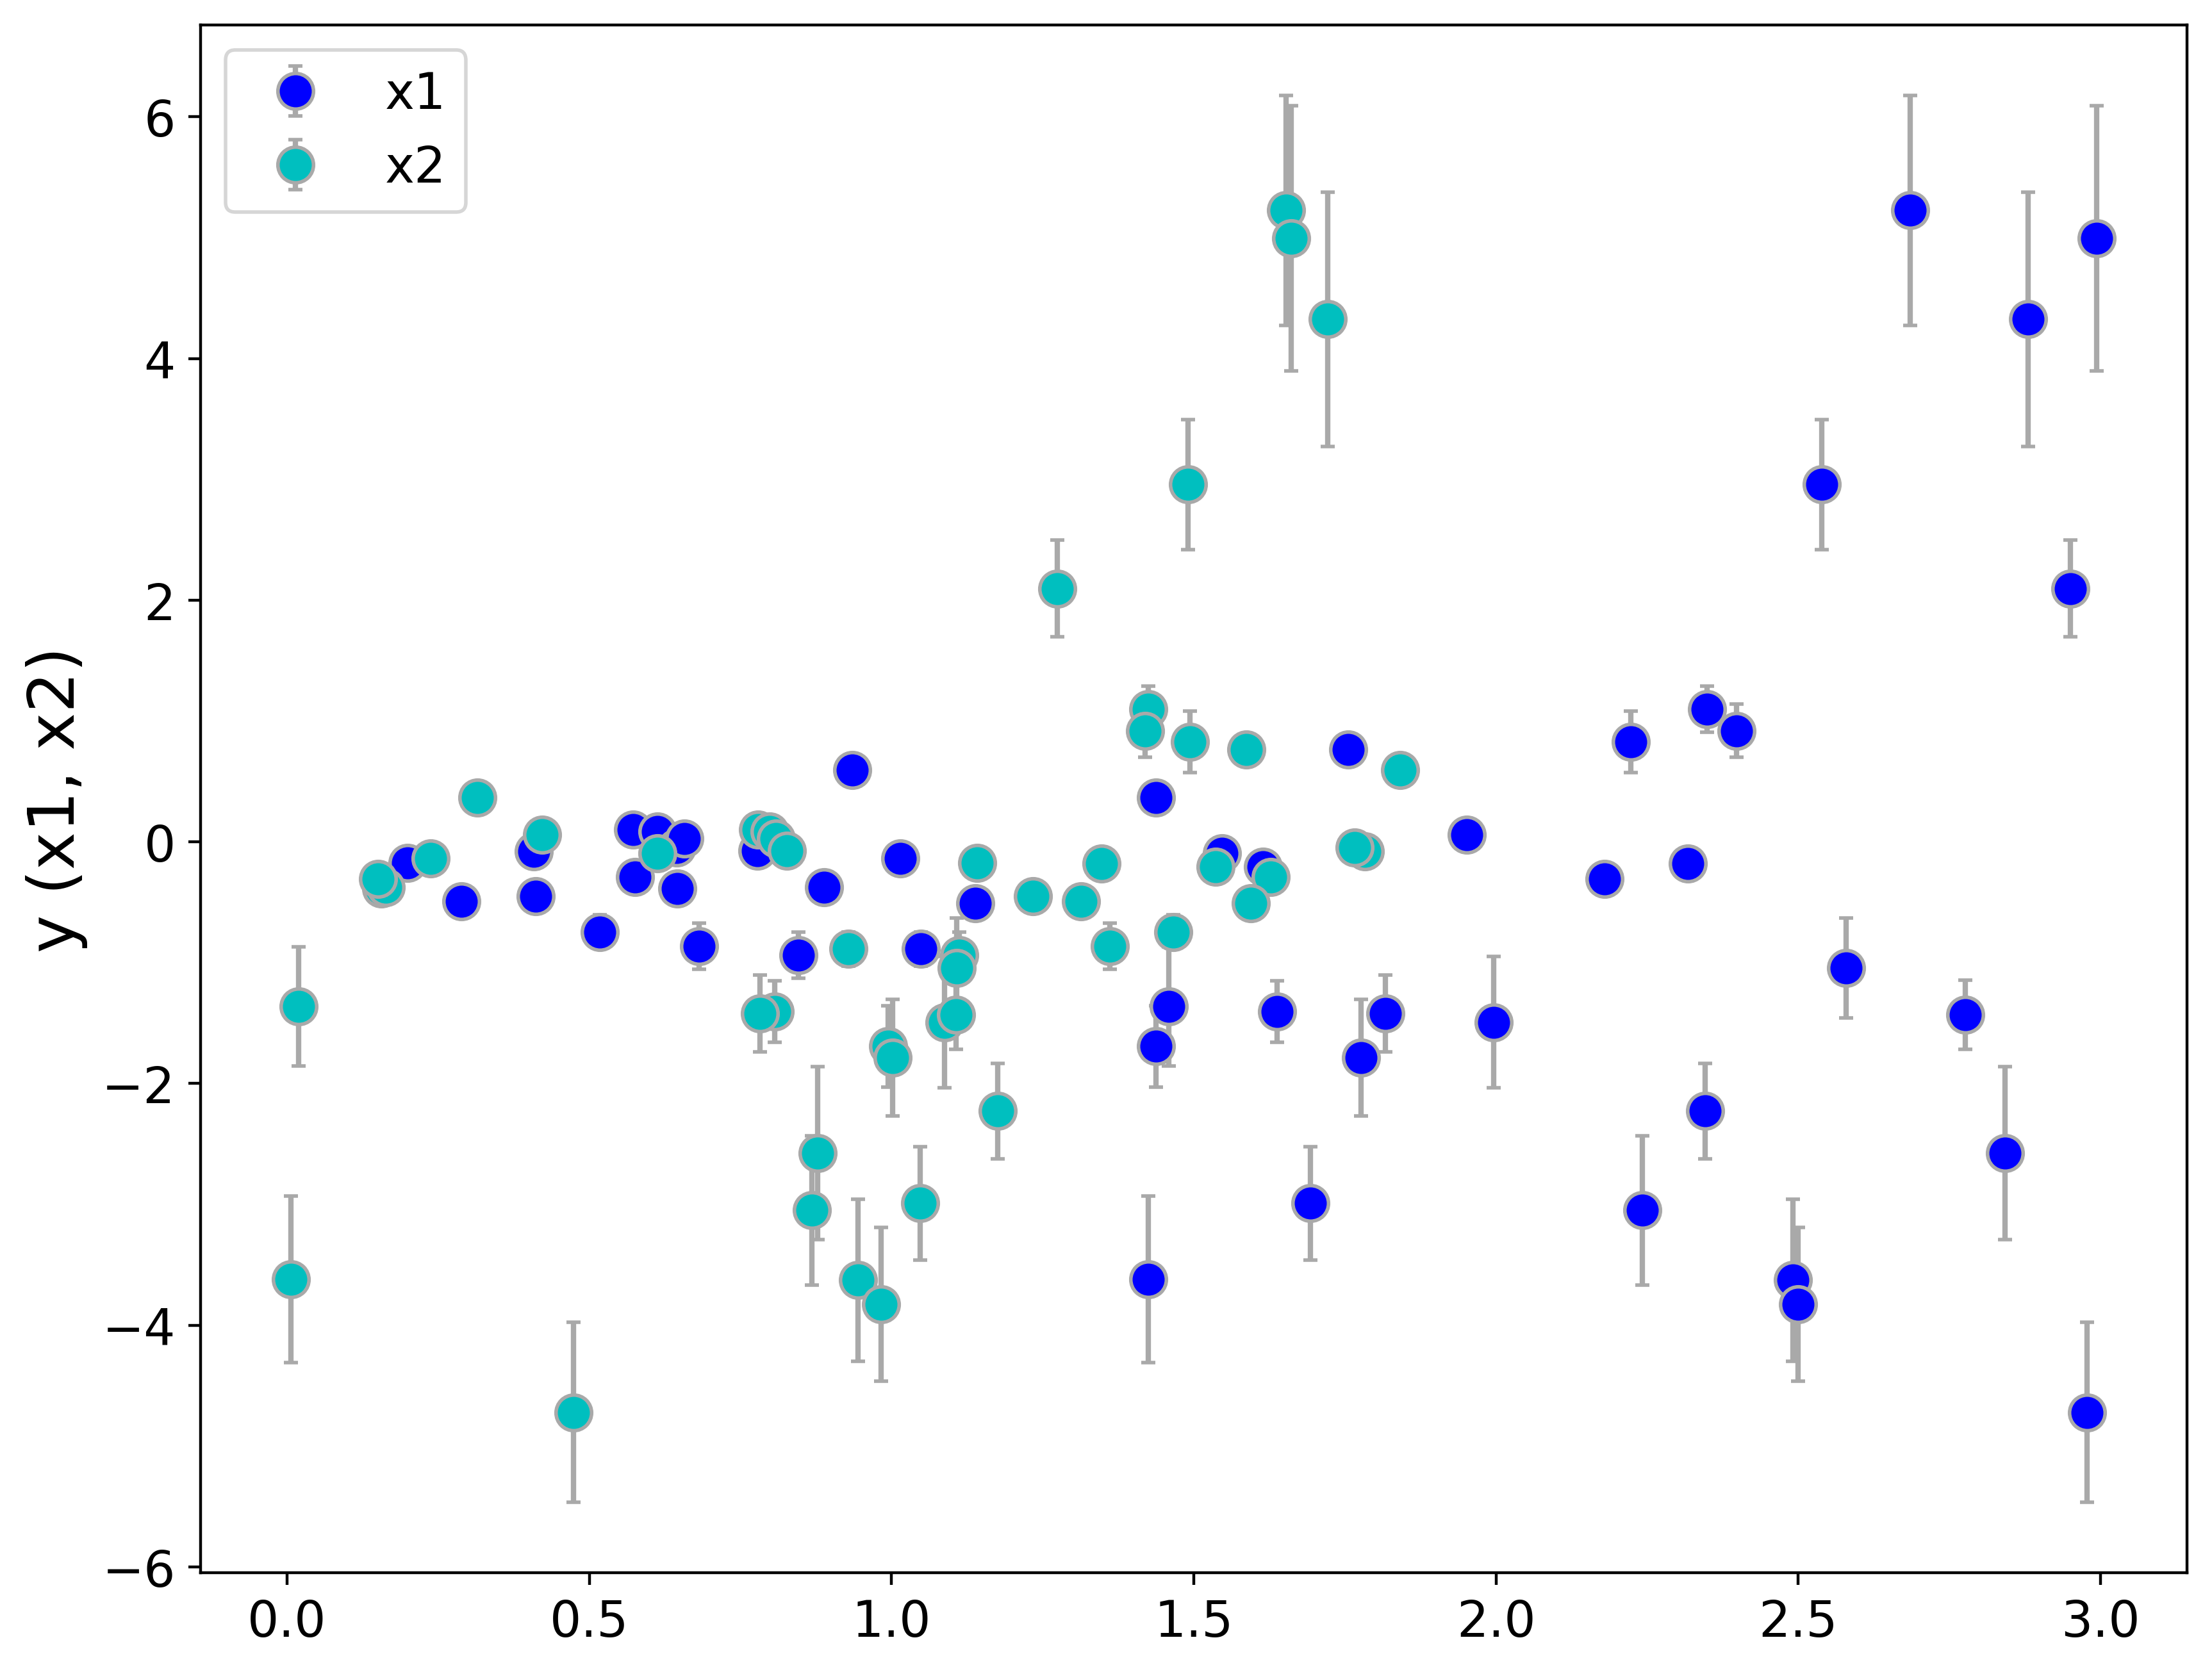

In [4]:
plt.figure(figsize=(10,8), dpi = 200)
plt.errorbar(x1,y,yerr=yerr, fmt=".b", markersize = 20, markeredgecolor = 'darkgrey', ecolor='darkgrey', capsize=2, elinewidth=1.5, markeredgewidth=1, alpha = 1)
plt.errorbar(x2,y,yerr=yerr, fmt=".c", markersize = 20, markeredgecolor = 'darkgrey', ecolor='darkgrey', capsize=2, elinewidth=1.5, markeredgewidth=1)

plt.legend(["x1", "x2"], fontsize=14)
#plt.xlabel("x", fontsize= 18)
plt.ylabel("y (x1, x2)", fontsize= 18, rotation = 90)
plt.xticks(fontsize=14, rotation=0)
plt.yticks(fontsize=14, rotation=0)
plt.show()

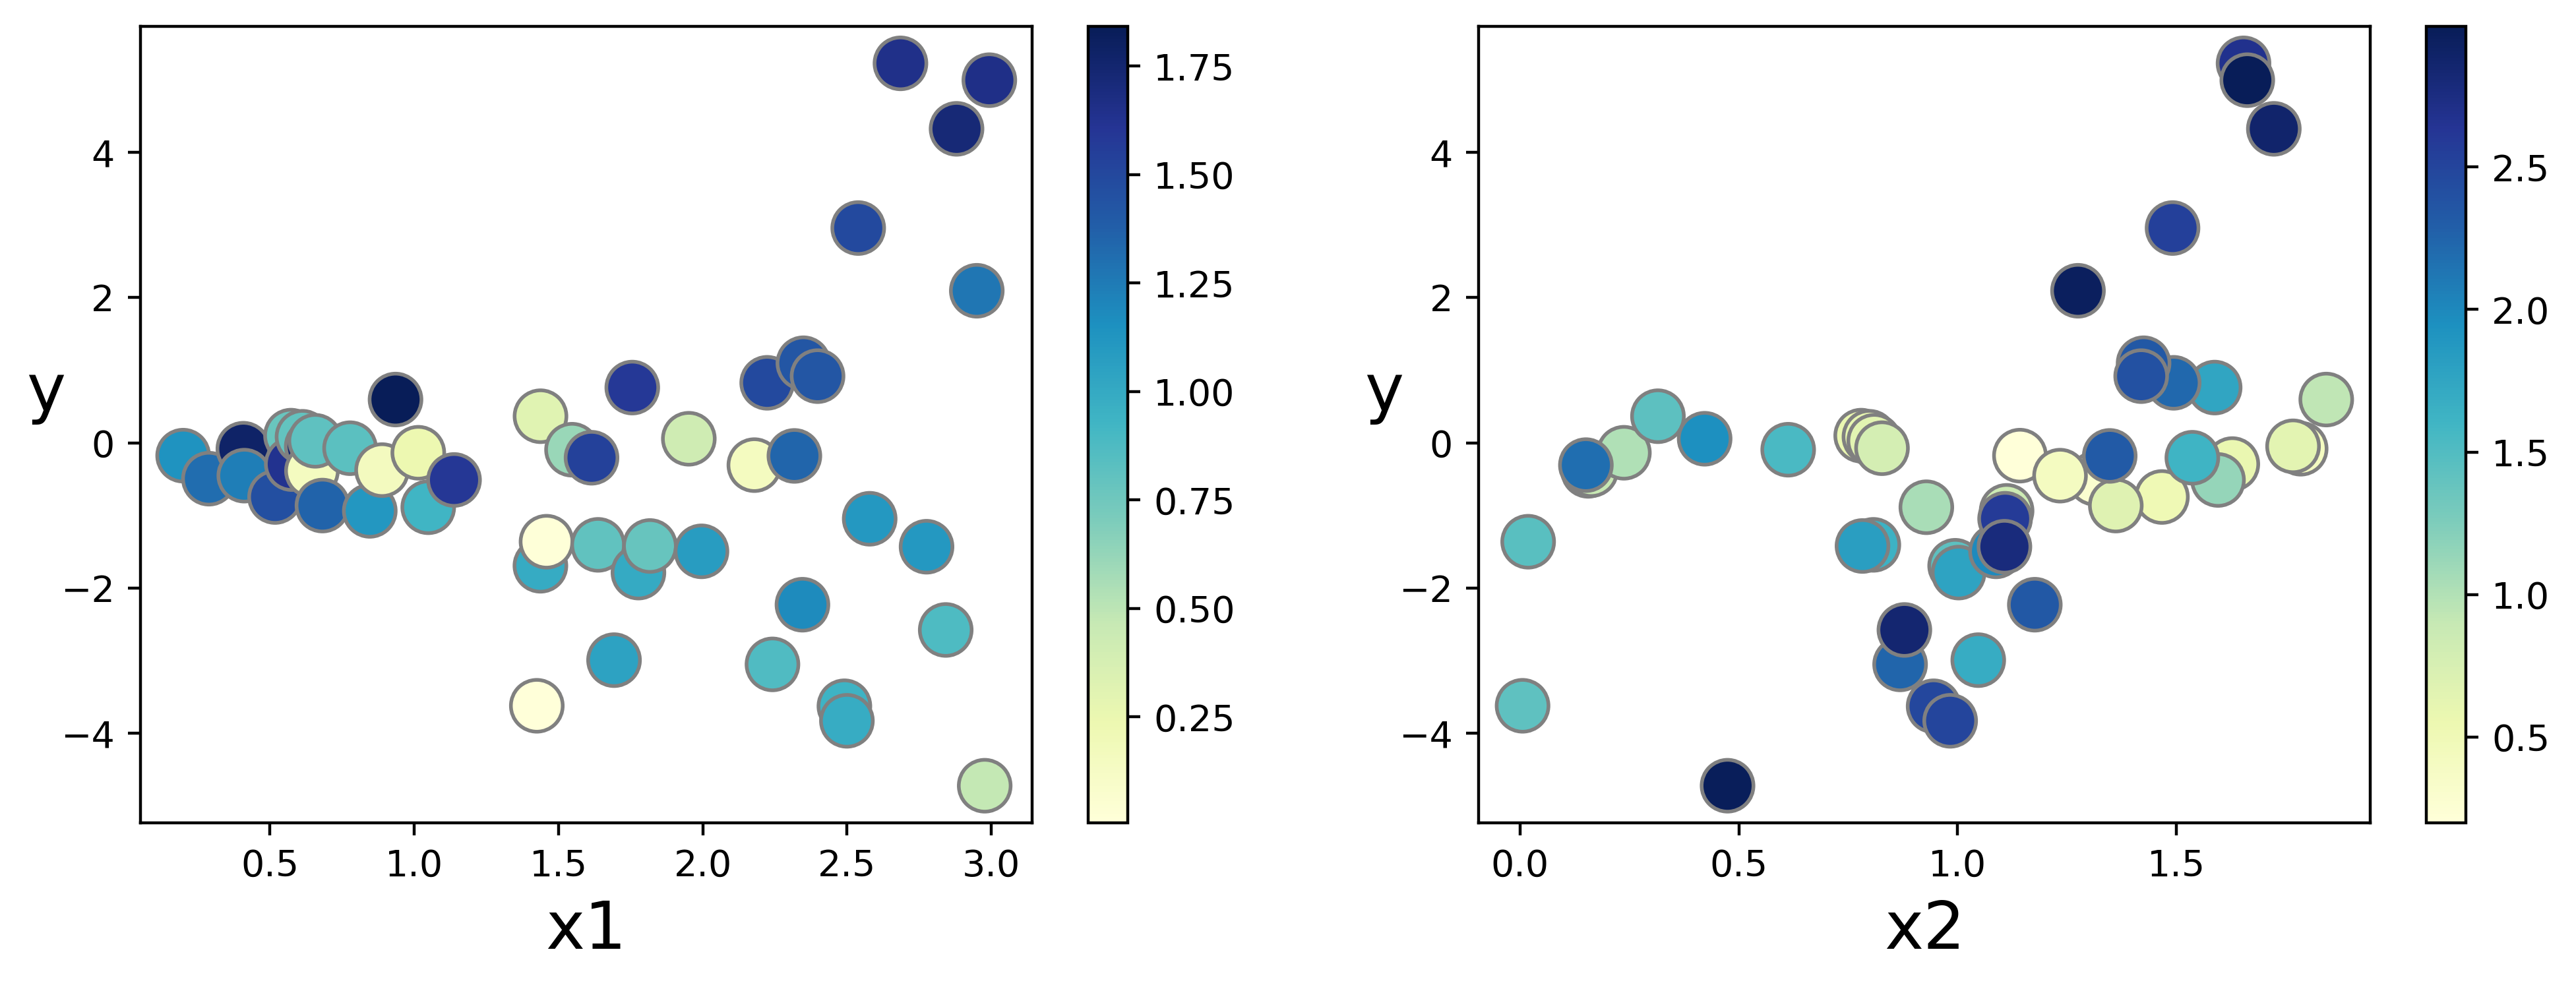

In [5]:
cm = plt.cm.get_cmap('YlGnBu')
plt.figure(figsize=(12,4), dpi = 200)
plt.subplot(1,2,1)
plt.scatter(x1, y, c=x2, s=200, marker='o', edgecolor = 'gray', cmap=cm)
plt.colorbar()
plt.xlabel('x1', fontsize = 18)
plt.ylabel('y', fontsize = 18, rotation = 0)

plt.subplot(1,2,2)
plt.scatter(x2, y, c=x1, s=200, marker='o', edgecolor = 'gray', cmap=cm)
plt.colorbar()
plt.xlabel('x2', fontsize = 18)
plt.ylabel('y', fontsize = 18, rotation = 0)

plt.show()

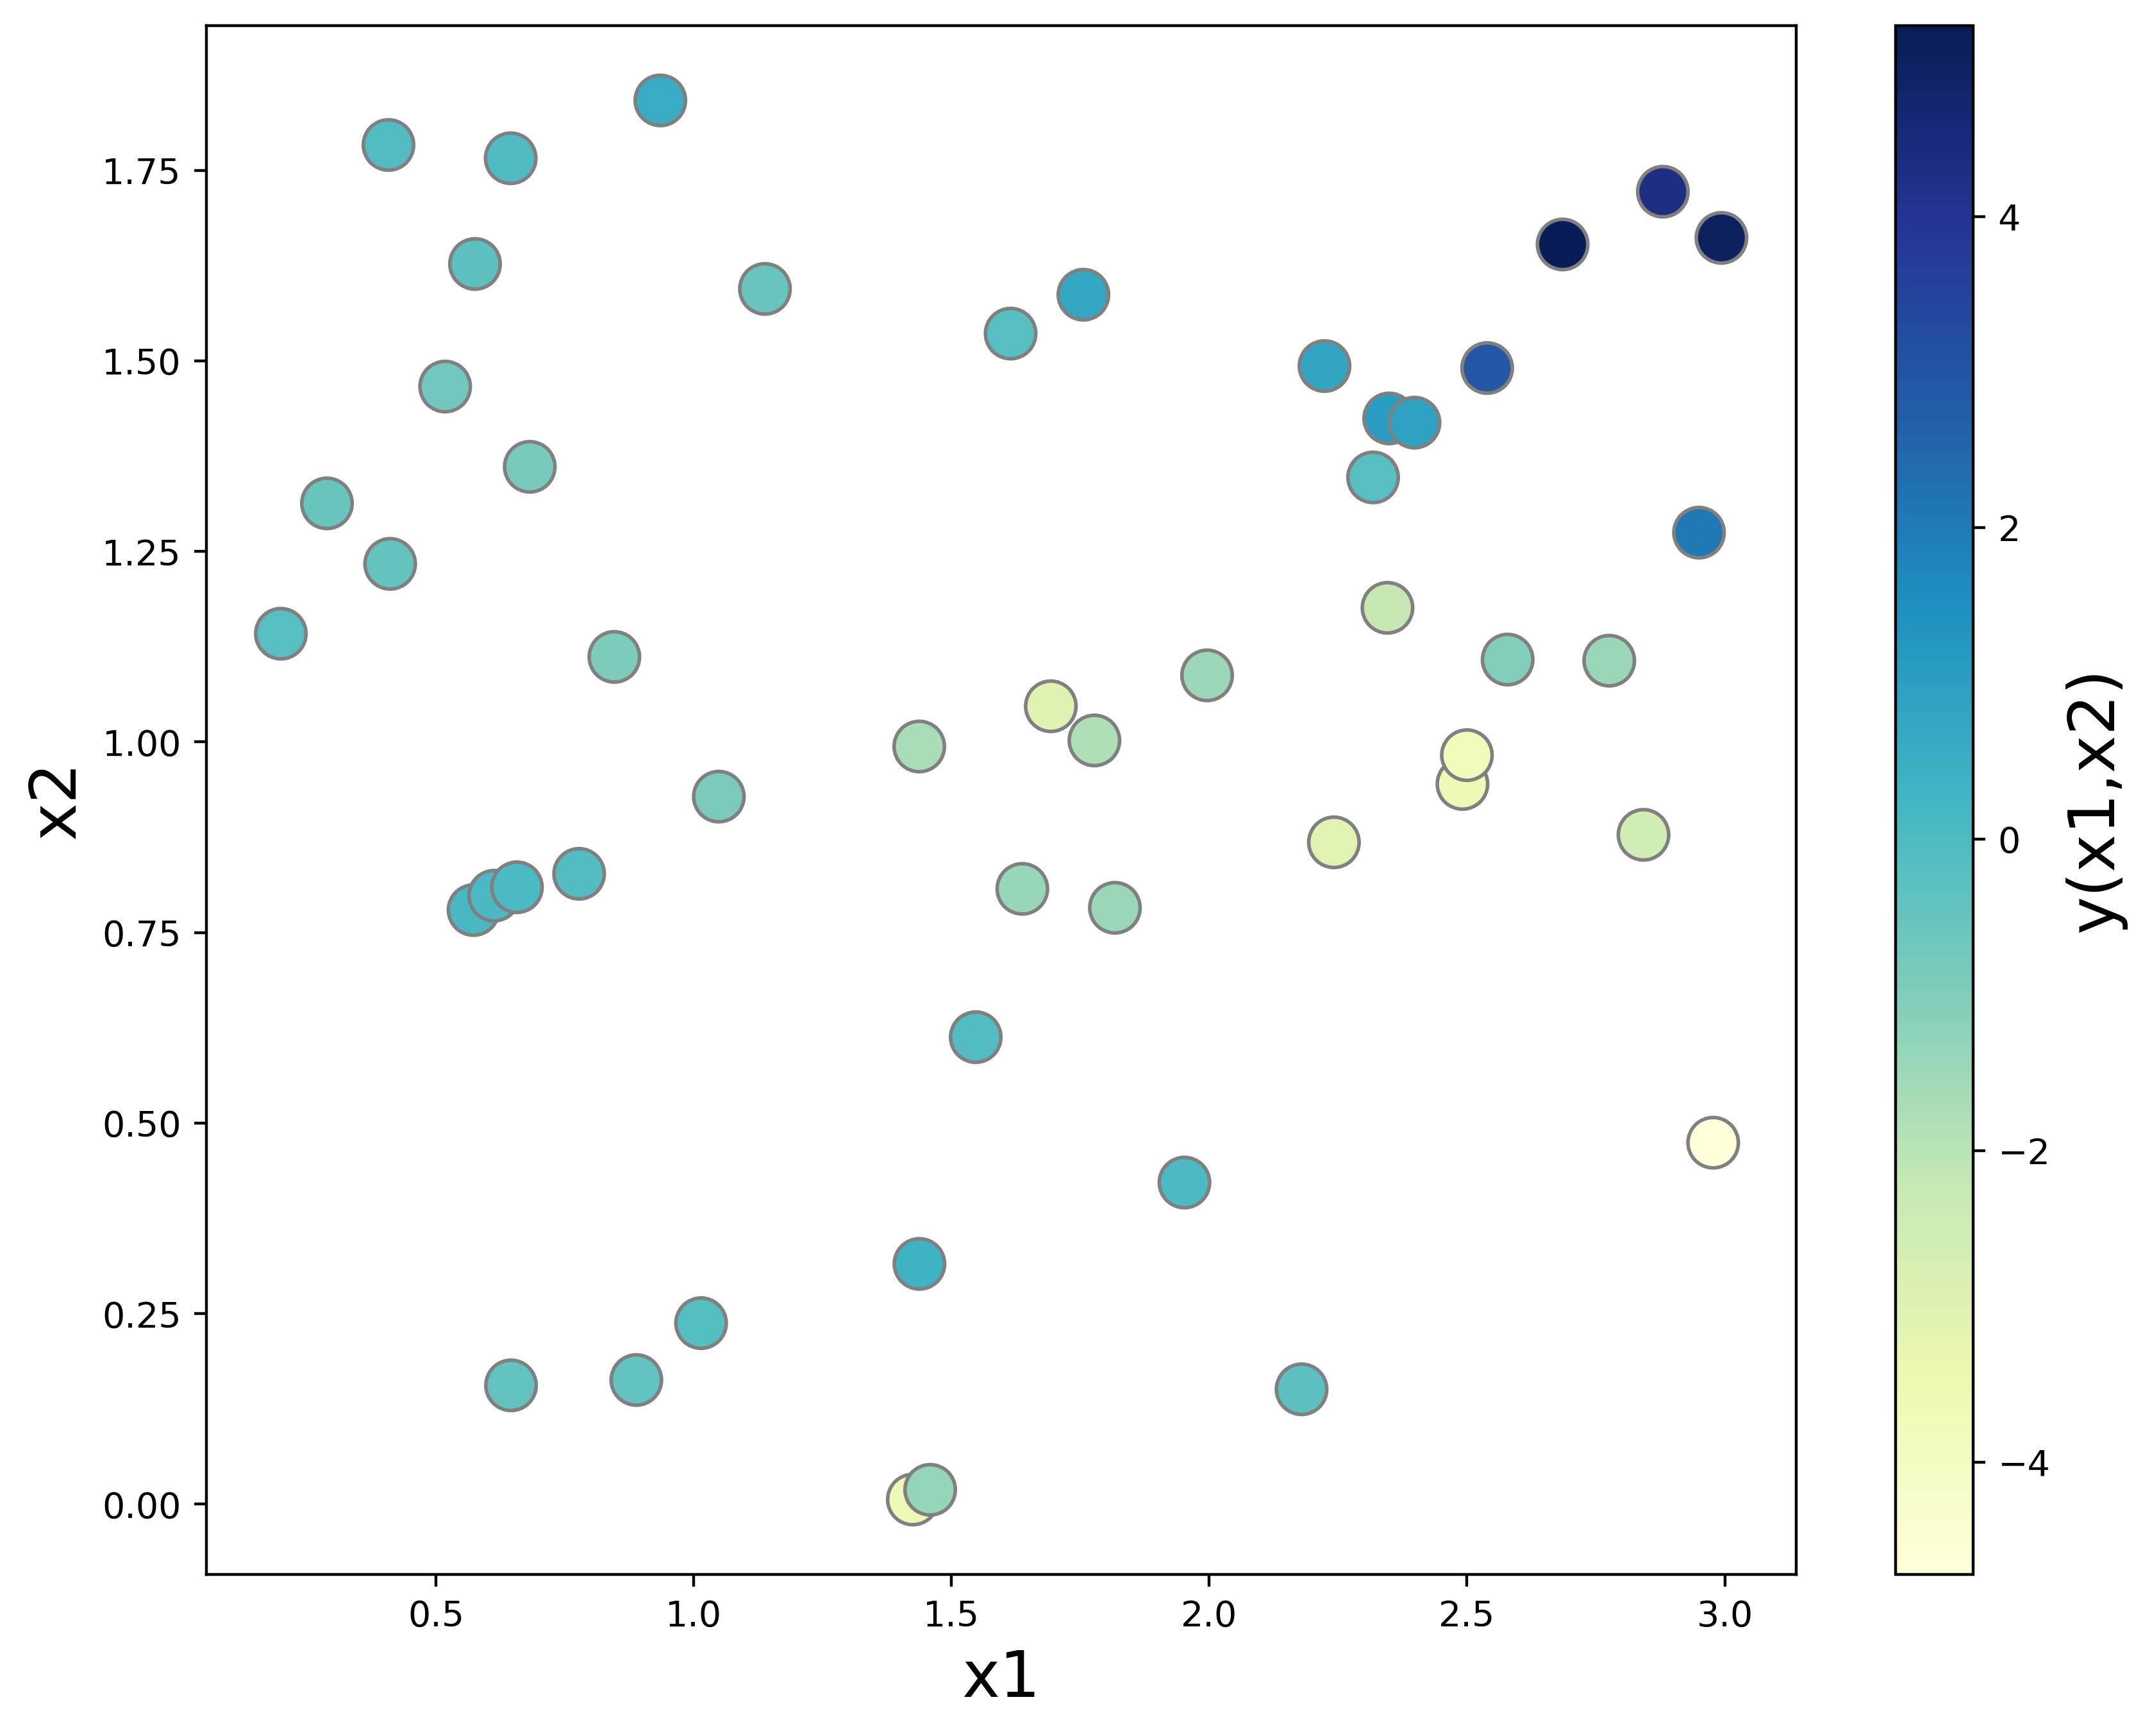

In [6]:
fig, ax = plt.subplots(figsize=(10,8), dpi = 200)
cm = plt.cm.get_cmap('YlGnBu')
scat = ax.scatter(x1, x2, c=y, s=200, marker='o', edgecolor = 'gray', cmap=cm)
cb = plt.colorbar(scat)
cb.set_label('y(x1,x2)', fontsize = 18)
plt.xlabel('x1', fontsize = 18)
plt.ylabel('x2', fontsize = 18, rotation = 90)
plt.show()

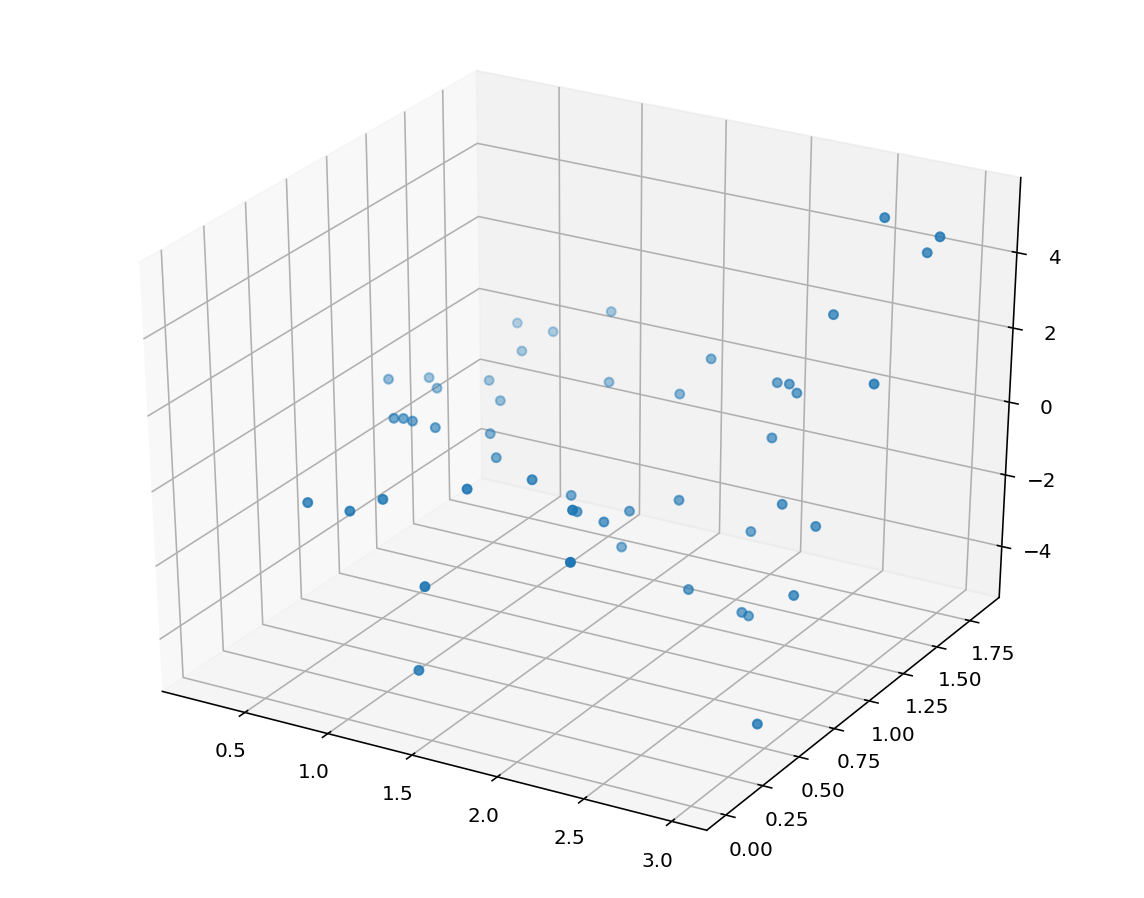

In [7]:
from mpl_toolkits.mplot3d import Axes3D 

fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x1, x2, y)
plt.show()

## Using sympy to evaluate the integral 

Sympy enables the user to evaluate an integral symbolically, then turn it into a numpy function which can then be used by the emcee module. 

In [8]:
import sympy as sym

x1, x2, a, b, c, d, x = sym.symbols('x1, x2, a, b, c, d, x')
f = sym.sin(a*x + b * x2) * (c*x**2 + sym.ln(d*x2))  
yx1x2 = sym.integrate(f, (x, 0, x1))  
 
f_mod = sym.lambdify( (x1, x2, a, b, c, d, x), yx1x2, 'numpy')

In [9]:
#import scipy as sy
#from scipy.integrate import quad 
#a = np.copy(a_approx)
#b = np.copy(b_approx)
#c = np.copy(c_approx)
#d = np.copy(d_approx)

#I = []
#def integrand(x, a, b, c, d):
#    return (np.sin(a*x + b*x2[i]) * (c*x**2 + np.log(d*x2[i])))
#
#integral = quad(integrand, 0, x1.all(), args = (a,b,c,d))
##for i in range(len(x1)):
##    integral = quad(integrand, 0, x1[i], args = (a,b,c,d))
##    I.append(integral)
#
##plt.figure(figsize=(10,8))
##plt.plot(x1, I, '.k')
##plt.plot(x2, I, '.b')
##plt.show()


## emcee: Maximum likelihood, corner plot, projection of posterior samples

In [10]:
def log_likelihood(theta, x1, x2, y, yerr, f_mod): 
    a, b, c, d, log_f = theta
    model =  f_mod
    sigma2 = yerr ** 2 + model(x1, x2, a, b, c, d, x)**2*np.exp(2*log_f)
    return -0.5 * np.sum((y-model(x1, x2, a ,b, c, d, x))**2/sigma2 + np.log(sigma2))

In [11]:
from scipy.optimize import minimize

x1 = np.copy(var1)
x2 = np.copy(var2)
y = np.copy(var3)
yerr = np.copy(var4)

np.random.seed(42)
n11 = lambda *args: -log_likelihood(*args)
initial = np.array([a_approx, b_approx, c_approx, d_approx, np.log(f_approx)]) + 0.1*np.random.randn(5)
soln = minimize(n11, initial, args=(x1, x2, y, yerr, f_mod))
a_ml, b_ml, c_ml, d_ml, log_f_ml = soln.x

print("Maximum likelihood estimates:")
print("a = {0:0.3f}".format(a_ml))
print("b = {0:0.3f}".format(b_ml))
print("c = {0:0.3f}".format(c_ml)) 
print("d = {0:0.3f}".format(d_ml)) 
print("f = {0:0.3f}".format(np.exp(log_f_ml)))


Maximum likelihood estimates:
a = 1.987
b = 3.015
c = 1.519
d = 2.323
f = 1.312


In [12]:
def log_prior(theta): 
    a, b, c, d, log_f = theta
    if 0.0 < a < 5.0 and 0.0 < b < 5.0 and 0.0 < c < 5.0 and 0.0 < d < 5.0 and -100. < log_f < 100.: 
        return 0.0
    return -np.inf

In [13]:
def log_probability(theta, x1, x2, y, yerr):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, x1, x2, y, yerr, f_mod)

In [14]:
import emcee

pos = soln.x + 1e-4 * np.random.randn(100, 5)
nwalkers, ndim = pos.shape

print(nwalkers)
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(x1, x2, y, yerr))
sampler.run_mcmc(pos, 5000)#, progress=True);

100


(array([[  1.26057461,   3.28989448,   0.54049682,   3.0218004 ,
         -15.02608279],
        [  1.2533912 ,   3.29202588,   0.57620294,   2.9671883 ,
         -12.86225018],
        [  1.24800291,   3.30026222,   0.55222269,   3.02937669,
          -3.11452036],
        [  1.26811667,   3.29350396,   0.49015803,   3.10396734,
         -19.92053445],
        [  1.24919097,   3.29725269,   0.5418822 ,   3.00241104,
         -57.93723682],
        [  1.2575556 ,   3.30124883,   0.53304434,   3.05325882,  -4.5752486 ],
        [  1.26331949,   3.29543059,   0.50272244,   3.0901331 ,
          -7.82144056],
        [  1.26725277,   3.29591785,   0.50698781,   3.16106371,
         -10.85041967],
        [  1.26581655,   3.30355476,   0.48632257,   3.09244906,
         -10.16871572],
        [  1.2441954 ,   3.29753377,   0.580793  ,   2.91306099,
          -2.71705388],
        [  1.27489267,   3.2980257 ,   0.4708027 ,   3.14166122,
         -11.39683694],
        [  1.2294113 ,   3.308

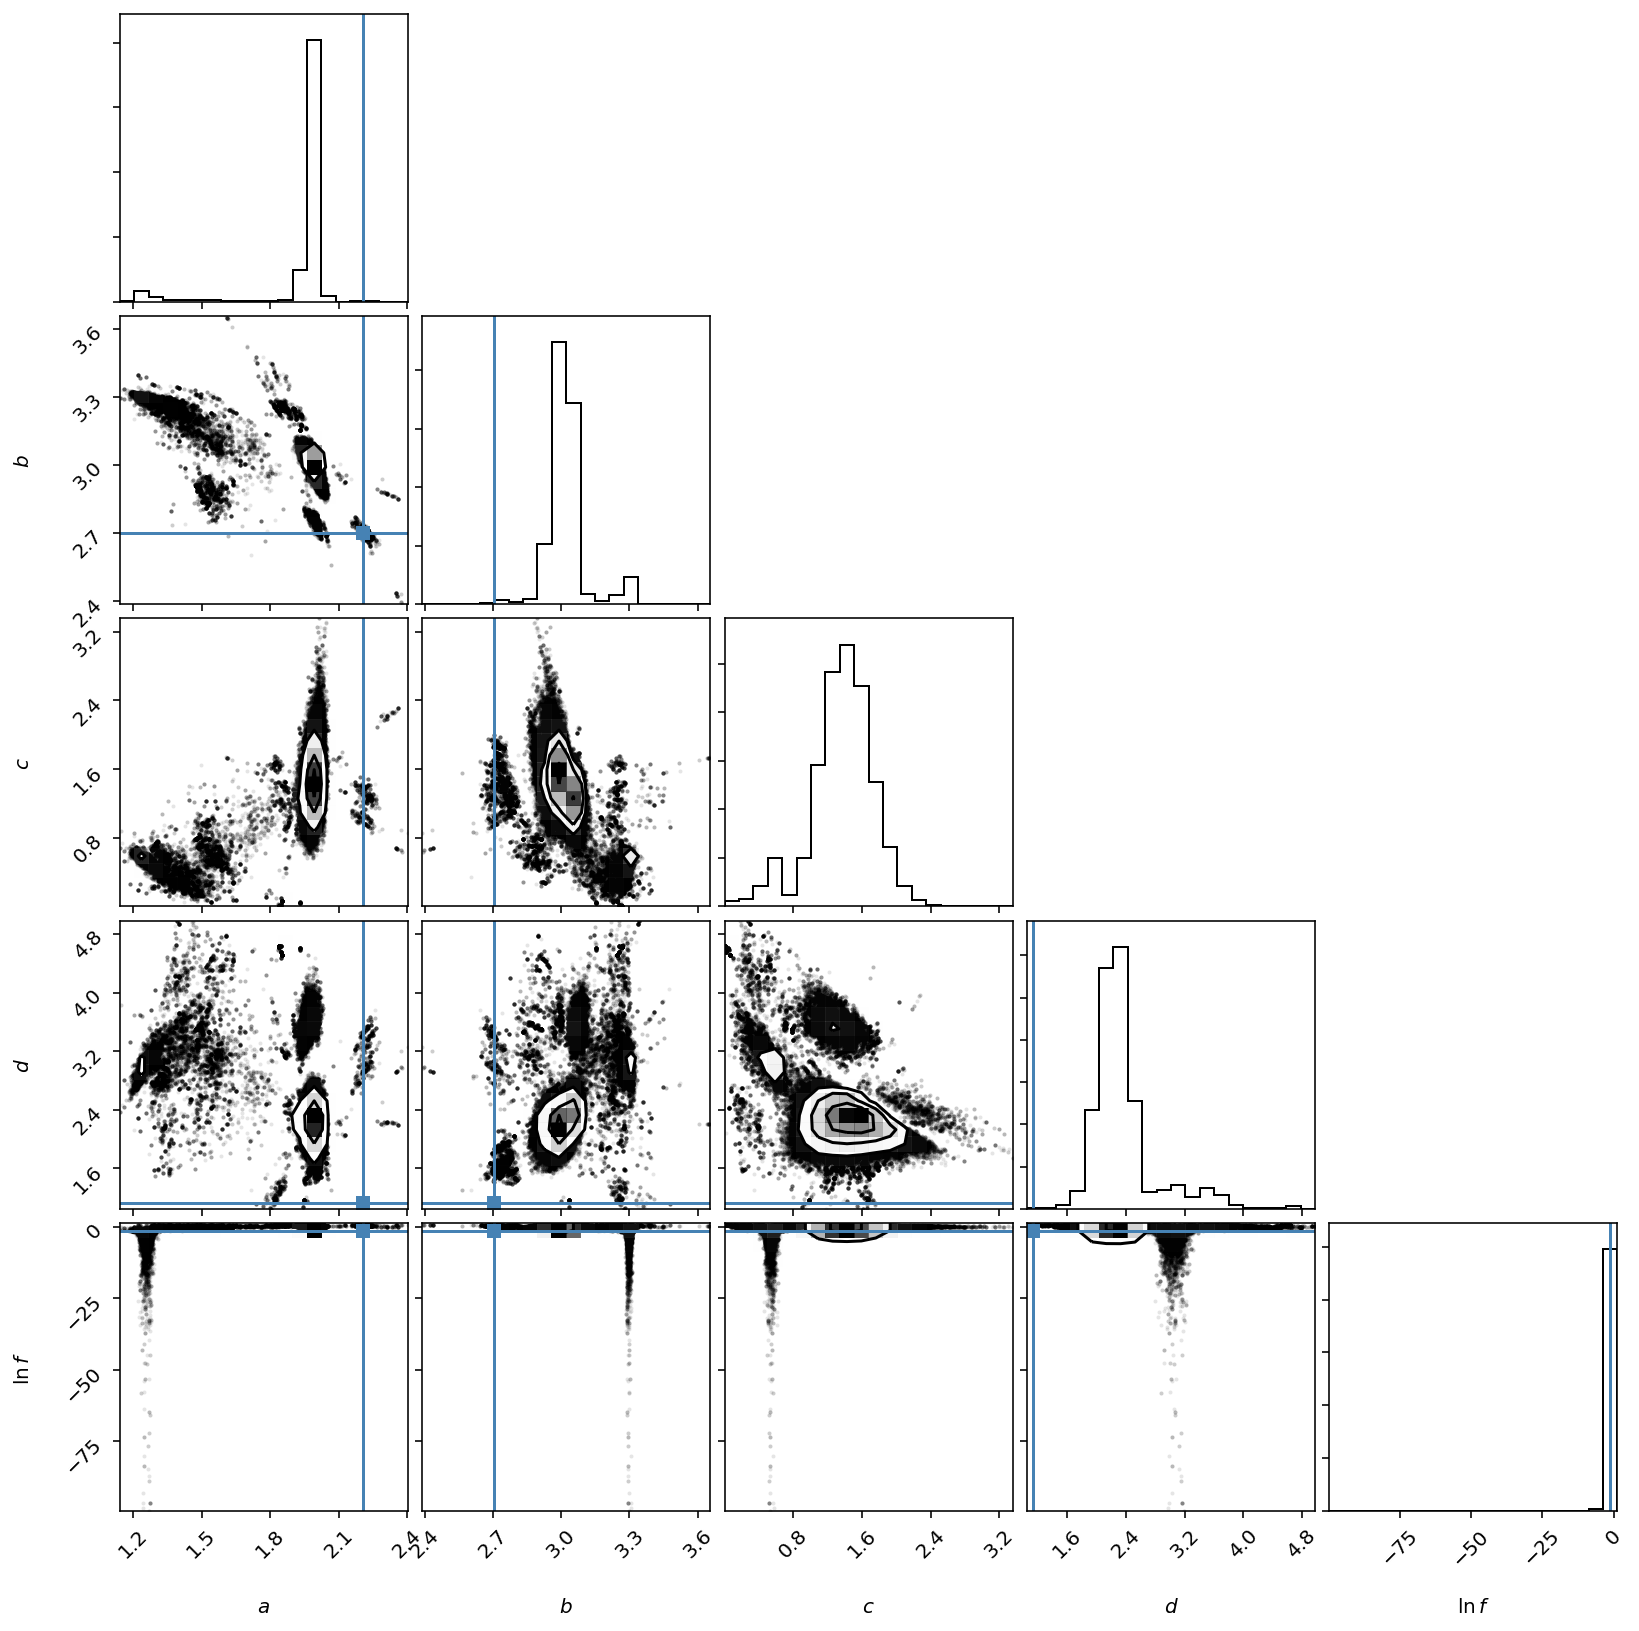

In [15]:
samples = sampler.chain[:, :, :].reshape((-1,ndim))

import corner
fig = corner.corner(samples, labels=["$a$", "$b$", "$c$", "$d$","$\ln\,f$"],
truths=[a_approx, b_approx, c_approx, d_approx, np.log(f_approx)], figsize=(10,10))
fig.savefig("triangle.png")

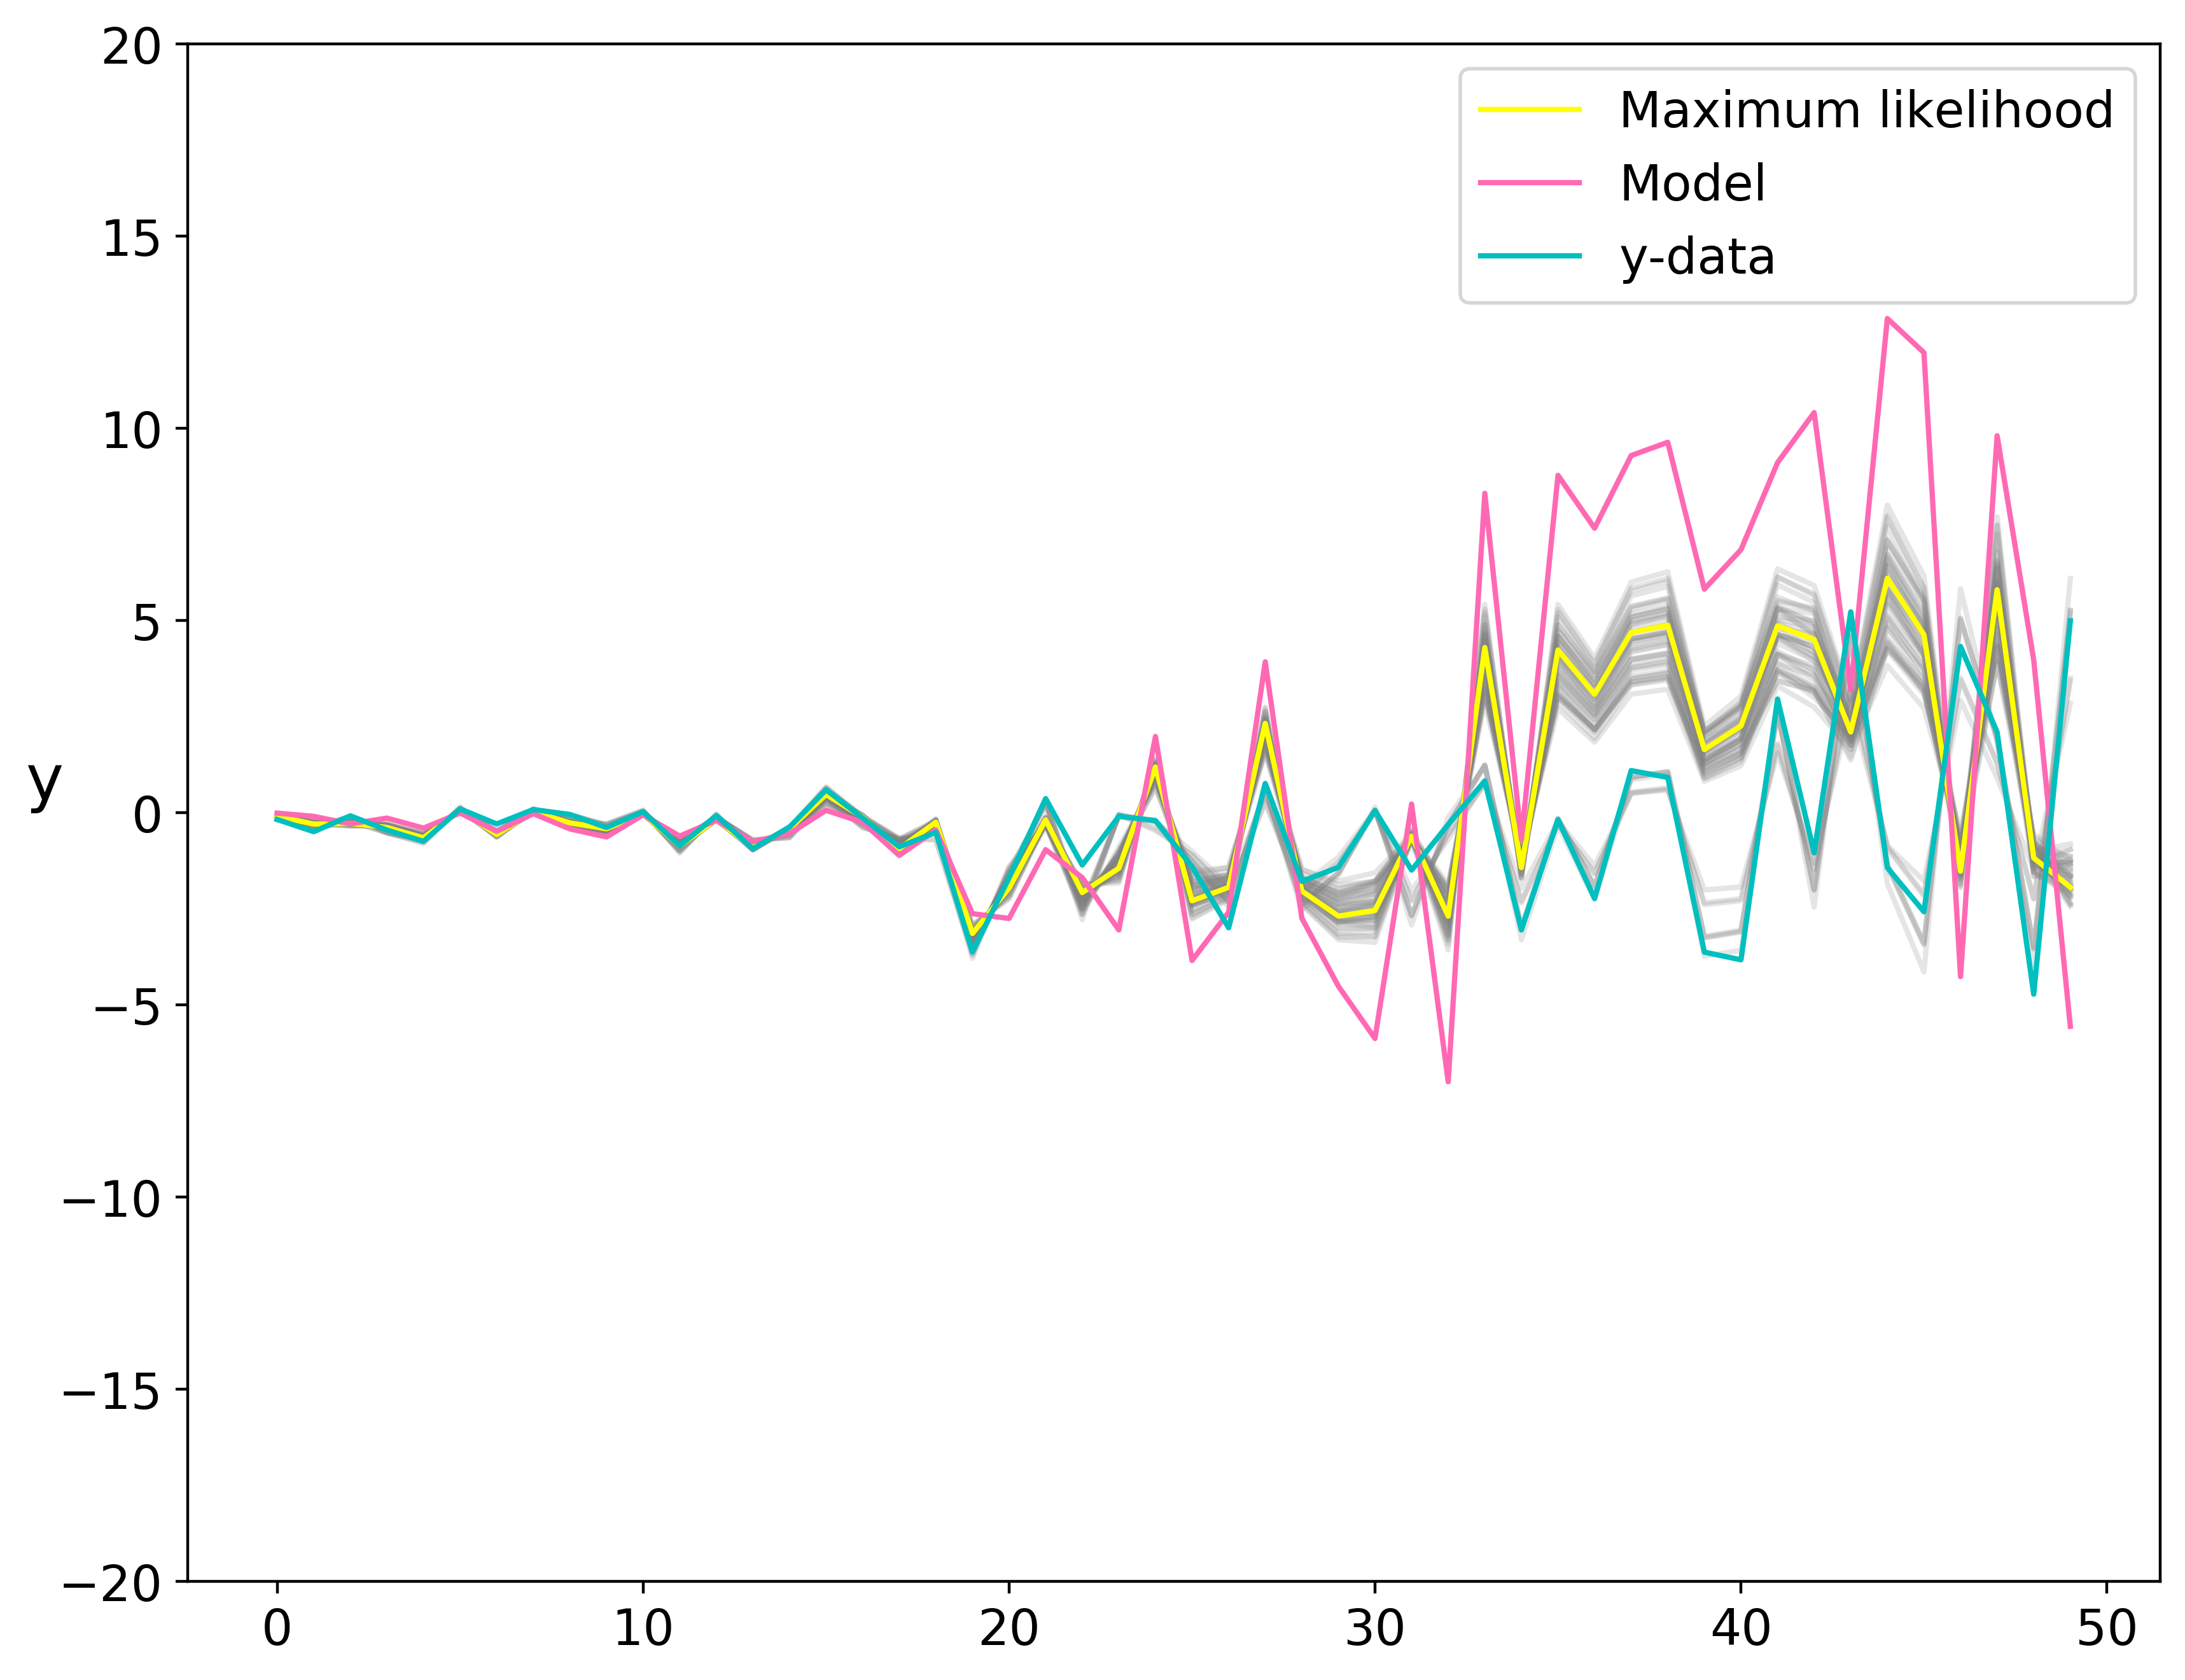

In [16]:
a_list = []
b_list = []
c_list = []
d_list = []
lnf_list = []

for a, b, c, d, lnf in samples[np.random.randint(len(samples), size=100)]:
    a_list.append(a)
    b_list.append(b)
    c_list.append(c)
    d_list.append(d)
    lnf_list.append(lnf)

plt.figure(figsize=(10,8), dpi = 200)
for i in range(len(x1)): 
    plt.plot(f_mod(x1, x2, a_list[i],b_list[i],c_list[i],d_list[i], x), color="gray", alpha=0.2)

plt.plot(f_mod(x1, x2, a_ml,b_ml,c_ml,d_ml, x), "yellow", label="Maximum likelihood")
plt.plot(f_mod(x1, x2, a_approx,b_approx,c_approx,d_approx, x), "hotpink", label="Model")
plt.plot(y, 'c',  label="y-data")
plt.legend(fontsize=14)
#plt.xlabel("x1, x2", fontsize= 18)
plt.ylabel("y", fontsize= 18, rotation =0)
plt.xticks(fontsize=14, rotation=0)
plt.yticks(fontsize=14, rotation=0)
plt.ylim(-20,20)
plt.show()

In [17]:
samples[:,2] = np.exp(samples[:,2])
a_mcmc, b_mcmc, c_mcmc, d_mcmc, f_mcmc = map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]), zip(*np.percentile(samples, [16, 50, 84], axis=0)))

In [18]:
print("MCMC estimates:")
print("a = ",a_mcmc[0], ",", "+", a_mcmc[1], ",", "-", a_mcmc[2]) 
print("b = ",b_mcmc[0], ",", "+", b_mcmc[1], ",", "-", b_mcmc[2]) 
print("c = ",c_mcmc[0], ",", "+", c_mcmc[1], ",", "-", c_mcmc[2]) 
print("d = ",d_mcmc[0], ",", "+", d_mcmc[1], ",", "-", d_mcmc[2]) 
print("f = ",f_mcmc[0], ",", "+", f_mcmc[1], ",", "-", f_mcmc[2]) 
print("---------------------")
print("Initial guesstimates:")
print("a = {0:0.3f}".format(a_approx))
print("b = {0:0.3f}".format(b_approx))
print("c = {0:0.3f}".format(c_approx)) 
print("d = {0:0.3f}".format(d_approx)) 
print("f = {0:0.3f}".format(f_approx)) 
print("---------------------")
print("Maximum likelihood estimates:")
print("a = {0:0.3f}".format(a_ml))
print("b = {0:0.3f}".format(b_ml))
print("c = {0:0.3f}".format(c_ml)) 
print("d = {0:0.3f}".format(d_ml)) 
print("f = {0:0.3f}".format(np.exp(log_f_ml)))

MCMC estimates:
a =  1.98455749906 , + 0.0197732876071 , - 0.0242336445511
b =  3.01510086663 , + 0.0400432934707 , - 0.0453177842449
c =  4.0591295214 , + 1.41511946958 , - 1.09467600699
d =  2.26854193913 , + 0.282741293845 , - 0.222187541718
f =  0.320256119211 , + 0.158857584024 , - 0.15093569843
---------------------
Initial guesstimates:
a = 2.207
b = 2.702
c = 3.495
d = 1.131
f = 0.291
---------------------
Maximum likelihood estimates:
a = 1.987
b = 3.015
c = 1.519
d = 2.323
f = 1.312
